In [159]:
from numpy.linalg import norm
import numpy as np

# value openness
value_openness = .4

n_connections_per_person = 4

# value alignment for each person
values = np.random.random((100, 2))
values

array([[0.50541276, 0.96489386],
       [0.69923343, 0.51486219],
       [0.51818961, 0.55622392],
       [0.82471679, 0.85683328],
       [0.03003602, 0.40893862],
       [0.72340702, 0.45851414],
       [0.96031095, 0.91176534],
       [0.77762674, 0.93060203],
       [0.73366894, 0.62942441],
       [0.16556218, 0.52102087],
       [0.28297315, 0.949682  ],
       [0.84873053, 0.03402777],
       [0.67030246, 0.43412316],
       [0.10195847, 0.58346601],
       [0.73732509, 0.89413267],
       [0.93932095, 0.08508319],
       [0.66873754, 0.02710137],
       [0.93756584, 0.15149255],
       [0.45837504, 0.28230035],
       [0.80052405, 0.13128764],
       [0.49238007, 0.70684337],
       [0.37129101, 0.90424873],
       [0.38671108, 0.6224561 ],
       [0.32006823, 0.93773524],
       [0.21180011, 0.90088257],
       [0.62984921, 0.64543132],
       [0.78963413, 0.89228071],
       [0.54353751, 0.34561676],
       [0.04952843, 0.59392552],
       [0.62928888, 0.32419132],
       [0.

In [160]:
accepted = norm(values, axis=1) < value_openness
user_values = values[accepted]
n_users = len(user_values)
user_values

array([[0.06802643, 0.27465137],
       [0.23442792, 0.23371869],
       [0.05500204, 0.15545015],
       [0.01122013, 0.17282004],
       [0.14212951, 0.13627496],
       [0.12259992, 0.32190149],
       [0.02981777, 0.24087601],
       [0.23263987, 0.08577908]])

In [161]:
# user_values[0] = [0, 0]
# user_values[3] = [0, 0]
# user_values[2] = [openness] * 2
user_values

array([[0.06802643, 0.27465137],
       [0.23442792, 0.23371869],
       [0.05500204, 0.15545015],
       [0.01122013, 0.17282004],
       [0.14212951, 0.13627496],
       [0.12259992, 0.32190149],
       [0.02981777, 0.24087601],
       [0.23263987, 0.08577908]])

In [162]:
import numpy as np
import random
from collections import defaultdict


def make_connections(n, n_connections_per_person):
    """
    Generate a symmetric undirected graph where each person has exactly
    `n_connections_per_person` mutual connections.

    Assumes:
    - n_connections_per_person < n
    - (n * n_connections_per_person) must be even (required for undirected graph)

    Returns:
        A dict mapping each person to a set of their connected people.
    """
    if n_connections_per_person >= n:
        raise ValueError("Each person must have fewer connections than total people.")

    if (n * n_connections_per_person) % 2 != 0:
        raise ValueError("Total number of connections must be even for mutual pairs.")

    connections = defaultdict(set)
    attempts = 0
    max_attempts = 10000  # to prevent infinite loops

    while True:
        # Clear previous attempts
        for k in connections:
            connections[k].clear()

        people = list(range(n))
        success = True

        for i in people:
            while len(connections[i]) < n_connections_per_person:
                possible = list(set(people) - connections[i] - {i})
                possible = [p for p in possible if len(connections[p]) < n_connections_per_person]
                if not possible:
                    success = False
                    break
                j = random.choice(possible)
                connections[i].add(j)
                connections[j].add(i)

            if not success:
                break

        if success:
            break

        attempts += 1
        if attempts > max_attempts:
            raise RuntimeError("Failed to generate a valid connection graph after many attempts.")

    return dict(connections)


connections = make_connections(len(user_values), n_connections_per_person=n_connections_per_person)
connections

{0: {2, 4, 6, 7},
 1: {2, 4, 5, 6},
 2: {0, 1, 4, 5},
 3: {4, 5, 6, 7},
 4: {0, 1, 2, 3},
 5: {1, 2, 3, 7},
 6: {0, 1, 3, 7},
 7: {0, 3, 5, 6}}

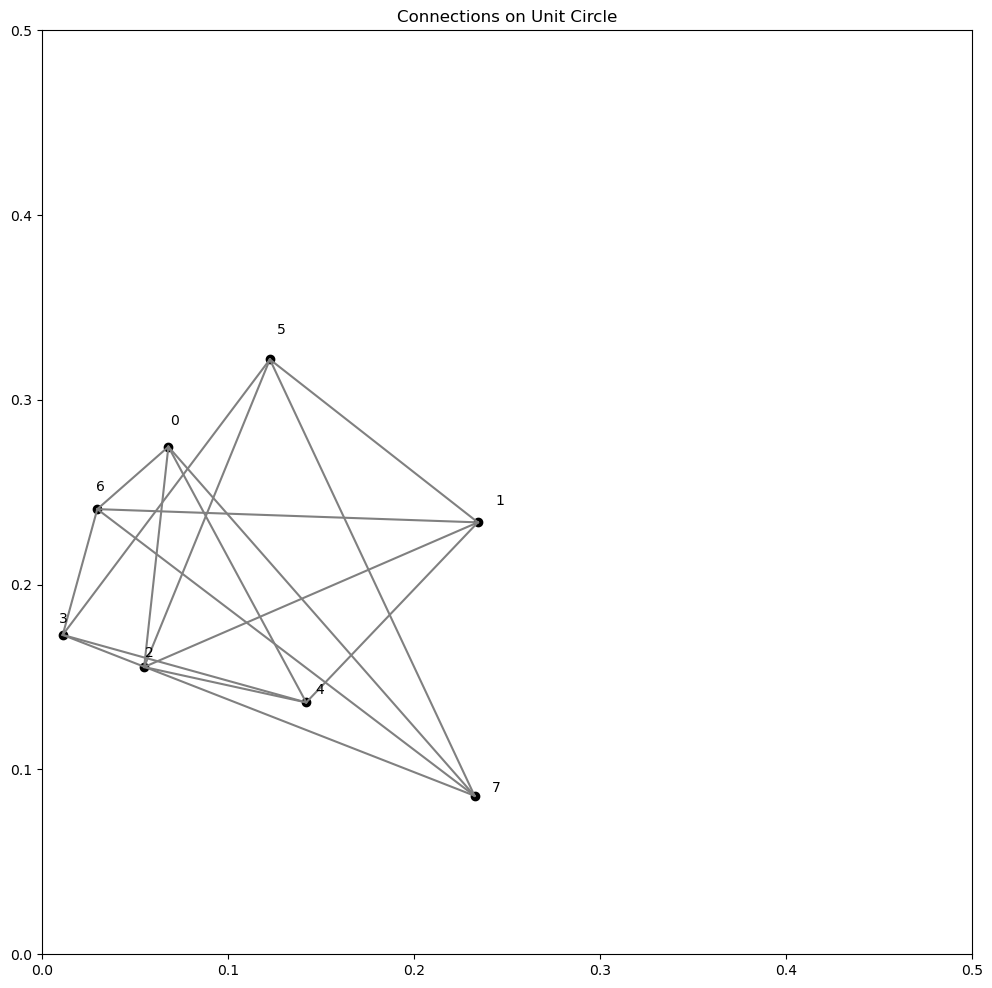

In [175]:
import numpy as np
import matplotlib.pyplot as plt


def plot_connections(connections):
    # n = len(connections)
    # angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    # positions = {i: (np.cos(a), np.sin(a)) for i, a in enumerate(angles)}
    positions = {i: a for i, a in enumerate(user_values)}

    fig, ax = plt.subplots(figsize=(12, 12))
    # openness = 1
    ax.set_xlim(0, openness)
    ax.set_ylim(0, openness)
    # ax.set_aspect('equal')
    # ax.axis('off')

    # Draw nodes
    for i, (x, y) in positions.items():
        ax.plot(x, y, 'o', color='black')
        ax.text(x * 1.05, y * 1.05, str(i), ha='center', va='center')

    # Draw edges
    drawn = set()
    for i, neighbors in connections.items():
        for j in neighbors:
            if str((j, i)) not in drawn:
                x0, y0 = positions[i]
                x1, y1 = positions[j]
                ax.plot([x0, x1], [y0, y1], color='gray')
                drawn.add(str((i, j)))

    plt.title("Connections on Unit Circle")
    plt.show()


plot_connections(connections)

In [173]:
q = []
d = len(user_values[0])
for i in range(n_users):
    other_values = user_values[list(connections[i])]
    user_value =  user_values[i]
    user_q = 1 - (norm(other_values - user_values[i], axis=1) / np.sqrt(d)) ** .2    # user_q = np.exp(-10 * norm(other_values - user_value, axis=1))
    # We are utilitarian but still give more importance to like-minded people
    # (whose values are closer to the target (0, 0))
    user_q /= norm(user_value) ** 2
    q.append(user_q)

print(connections)
q = np.array(q)
q

{0: {2, 4, 6, 7}, 1: {2, 4, 5, 6}, 2: {0, 1, 4, 5}, 3: {4, 5, 6, 7}, 4: {0, 1, 2, 3}, 5: {1, 2, 3, 7}, 6: {0, 1, 3, 7}, 7: {0, 3, 5, 6}}


array([[11.43141733, 11.10411335, 12.04007139, 10.27768479],
       [ 7.86251292,  8.25959871,  8.20670746,  7.80455785],
       [33.65984787, 31.68745496, 34.45818697, 32.10615569],
       [30.13716994, 28.95415839, 31.67817728, 27.73244701],
       [22.92927319, 23.34421467, 24.16499761, 23.31325723],
       [ 7.57933639,  7.35740309,  7.31902691,  6.87557107],
       [16.36282563, 14.51748755, 16.12811129, 13.91023066],
       [13.38402715, 13.52925221, 13.26942118, 13.32897048]])

In [165]:
Q = float(q.sum().sum())
print(n_users, 'users')
print('Mean Q:', Q / n_users)
print('Q:', Q)

8 users
Mean Q: 1.428071218800166
Q: 11.424569750401329
